# Task 1 (3 points)

Generate a toy dataset for the "XOR" problem:

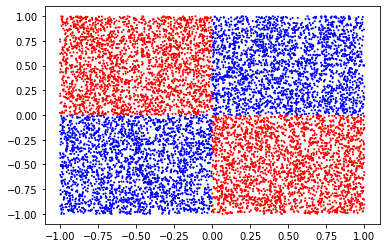

i.e. where the two features are distributed **uniformly** in $[-1, 1]$, and the target is $y = (x_0 >= 0) \text{ XOR } (x_1 >= 0)$.

Let the total number of points in the dataset be $N=10000$.

Fit a `sklearn.tree.DecisionTreeClassifier` on this data. Find a minimal `max_depth` value that results in train accuracy $>0.99$.

For each value of `max_depth` from 1 to the value found above, plot the data with the decision boundary for the obtained model. (*Hint: use `s=1` argument to `plt.scatter` to be able to see anything behind the data points.*)

For the model with train accuracy $>0.99$ use `sklearn.tree.plot_tree` to observe the tree structure.

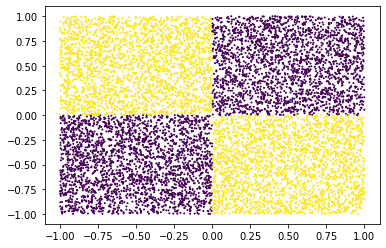

In [27]:
# Generate toy dataset

import numpy as np
import matplotlib.pyplot as plt

N = 10000

rng = np.random.RandomState(0)
X_toy = rng.uniform(-1,1,(N,2))
y_toy = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

plt.scatter(X[:, 0], X[:, 1], s=1, c=y_toy)



In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [45]:
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X_toy, y_toy)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [52]:
from sklearn.metrics import accuracy_score

def plot_decision_surface(
                  clf, X, y,
                  nx=200, ny=100,
                  cmap='bwr',
                  alpha=0.6,
        ):
    """
    Plot the decision boundary of clf on X and y, visualize training points
    """
    
    # Define the grid
    
    x_top_left = X.min(axis=0) - 1
    x_bottom_right = X.max(axis=0) + 1
    grid_x0, grid_x1 = np.meshgrid(
         np.linspace(x_top_left[0], x_bottom_right[0], ny),
         np.linspace(x_top_left[1], x_bottom_right[1], nx)
      )
    
    # Calculate predictions on the grid
    y_pred_grid = clf.predict(
                        np.stack(
                              [
                                grid_x0.ravel(),
                                grid_x1.ravel()
                              ],
                              axis=1
                            )
                      ).reshape(grid_x1.shape)
    
    # Find optimal contour levels and make a filled
    # contour plot of predictions
    labels = np.sort(np.unique(y))
    labels = np.concatenate([[labels[0] - 1],
                             labels,
                             [labels[-1] + 1]])
    medians = (labels[1:] + labels[:-1]) / 2
    plt.contourf(grid_x0, grid_x1, y_pred_grid, cmap=cmap, alpha=alpha,
                 levels=medians)
    
    # Scatter data points on top of the plot,
    # with different styles for correct and wrong
    # predictions
    y_pred = clf.predict(X)
    plt.scatter(*X[y_pred==y].T, c=y[y_pred==y],
                marker='o', cmap=cmap, s=1, label='correct')
    plt.scatter(*X[y_pred!=y].T, c=y[y_pred!=y],
                marker='x', cmap=cmap, s=1, label='errors')

    # Dummy plot call to print the accuracy in the legend.
    plt.plot([], [], ' ',
             label='Accuracy = {:.3f}'.format(accuracy_score(y, y_pred)))
    
    plt.legend(loc='best')

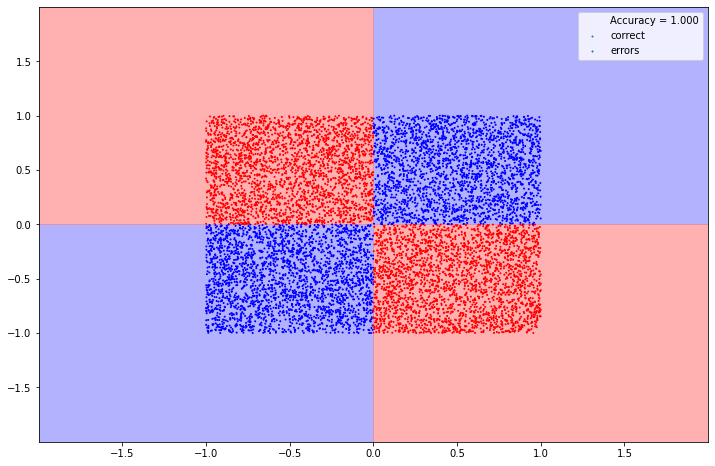

In [54]:
plt.figure(figsize=(12, 8))
plot_decision_surface(clf, X_toy, y_toy)

Answer:
max_depth for the train accuracy > 0.99 is max_depth=3

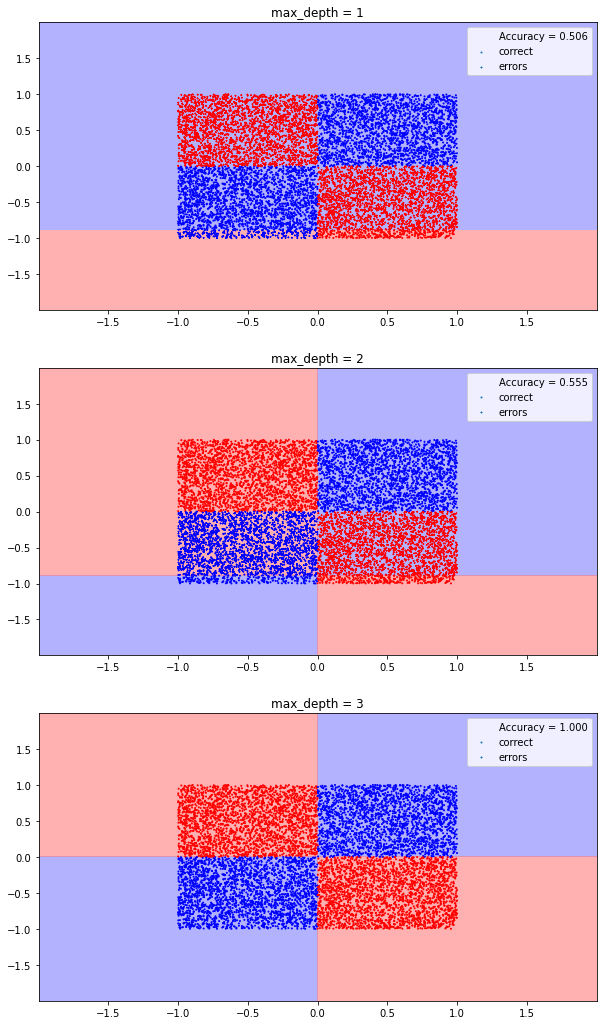

In [57]:
plt.figure(figsize=(10,18))
depth_values = [1,2,3]
for depth in depth_values:
  plt.subplot(3,1,depth)
  clf = DecisionTreeClassifier(max_depth=depth)
  clf.fit(X_toy, y_toy)
  plot_decision_surface(clf, X_toy, y_toy)
  plt.title('max_depth = ' + str(depth))

plt.show()

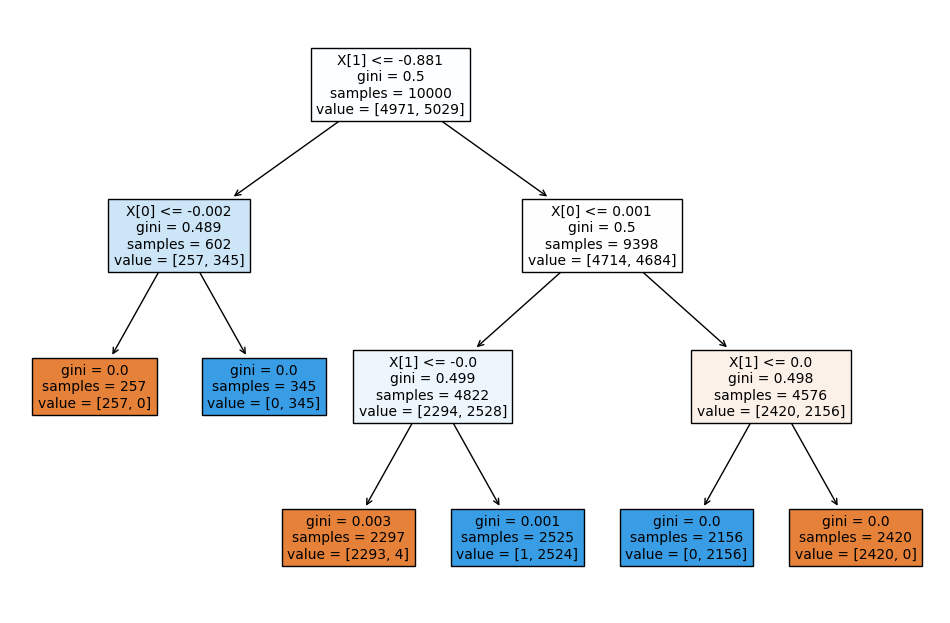

In [59]:
from sklearn.tree import plot_tree

plt.figure(figsize=(12, 8), dpi=100)
plot_tree(clf, max_depth=3, fontsize=10, filled=True);

# Task 2 (3 points)

Consider the following dataset:

In [60]:
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
print(data.DESCR)

X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target_names[data.target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12345)

print(X_train.iloc[:5])
print(y_train[:5])

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, f

Build a `sklearn.tree.DecisionTreeClassifier` to maximize the test ROC AUC score.

When predicting cancer, it's much more dangerous to have a false negative prediction rather than false positive. Try to find the best tree (in terms of test ROC AUC) where the labels are re-weighted with the `class_weight={'malignant' : 2., 'benign' : 1.}` argument provided to the `DecisionTreeClassifier` constructor.

Plot test ROC curves for the two best models you found on the same plot.

In [61]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve

In [165]:
def calculate_metrics(y_true, y_pred):
  precision = (y_true[y_pred == 1]).mean()
  recall = (y_pred[y_true == 1]).mean()
  f1 = 2 * precision * recall / (precision + recall)

  return (f1)

In [167]:
clf = DecisionTreeClassifier(class_weight={'malignant' : 2., 'benign' : 1.}, max_depth=10, max_features=10)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

y_pred_numerous = []
for i in range(len(y_pred)):
  if y_pred[i] == 'benign':
    y_pred_numerous.append(1)
  else:
        y_pred_numerous.append(0)

y_pred_numerous = np.array(y_pred_numerous)

y_test_numerous = []
for i in range(len(y_test)):
  if y_test[i] == 'benign':
    y_test_numerous.append(1)
  else:
    y_test_numerous.append(0)

y_test_numerous = np.array(y_test_numerous)

roc_score = calculate_metrics(y_test_numerous, y_pred_numerous)
print(roc_score)

0.9392265193370166


In [179]:
clf = DecisionTreeClassifier(class_weight={'malignant' : 2., 'benign' : 1.}, max_depth=8, max_features=15)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

y_pred_numerous = []
for i in range(len(y_pred)):
  if y_pred[i] == 'benign':
    y_pred_numerous.append(1)
  else:
        y_pred_numerous.append(0)

y_pred_numerous = np.array(y_pred_numerous)

y_test_numerous = []
for i in range(len(y_test)):
  if y_test[i] == 'benign':
    y_test_numerous.append(1)
  else:
    y_test_numerous.append(0)

y_test_numerous = np.array(y_test_numerous)

roc_score = calculate_metrics(y_test_numerous, y_pred_numerous)
print(roc_score)

0.9444444444444444


Text(0, 0.5, 'true positive rate')

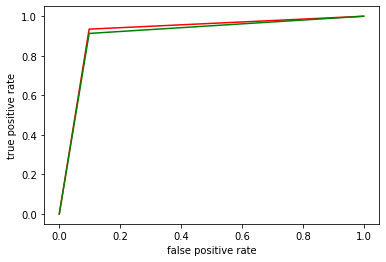

In [180]:
clf = DecisionTreeClassifier(class_weight={'malignant' : 2., 'benign' : 1.}, max_depth=10, max_features=10)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

y_pred_numerous = []
for i in range(len(y_pred)):
  if y_pred[i] == 'benign':
    y_pred_numerous.append(1)
  else:
    y_pred_numerous.append(0)

y_test_numerous = []
for i in range(len(y_test)):
  if y_test[i] == 'benign':
    y_test_numerous.append(1)
  else:
    y_test_numerous.append(0)

fpr, tpr, _ = roc_curve(y_test_numerous, y_pred_numerous)
plt.plot(fpr, tpr, 'r')

clf = DecisionTreeClassifier(class_weight={'malignant' : 2., 'benign' : 1.}, max_depth=8, max_features=15)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

y_pred_numerous = []
for i in range(len(y_pred)):
  if y_pred[i] == 'benign':
    y_pred_numerous.append(1)
  else:
    y_pred_numerous.append(0)

y_test_numerous = []
for i in range(len(y_test)):
  if y_test[i] == 'benign':
    y_test_numerous.append(1)
  else:
    y_test_numerous.append(0)

fpr, tpr, _ = roc_curve(y_test_numerous, y_pred_numerous)
plt.plot(fpr, tpr, 'g', label='discrete output')

plt.xlabel('false positive rate')
plt.ylabel('true positive rate')